In [1]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
PLOT_PARAMS()
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle
import thejoker as tj
import pymc as pm
import corner
import arviz as az
plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

08_14_25


In [9]:

rv_df   = pd.read_csv('rv_df.csv')
comb_df = pd.read_csv('combined_rvs.csv')
rv_df[rv_df['program']==112].RG_id.tolist()


[1, 2, 4, 5, 6, 7, 14, 23]

In [ ]:

ids = comb_df.GALAH_ID.unique()
for i in ids:
    dt = comb_df[comb_df.GALAH_ID==i]
    plt.scatter(dt.time, dt.rv)
    
    plt.title(rv_df[rv_df.galah_id==i].RG_id.values[0])
    plt.show()


<JokerSamples [P, e, omega, M0, s, K, v0] (318 samples)>


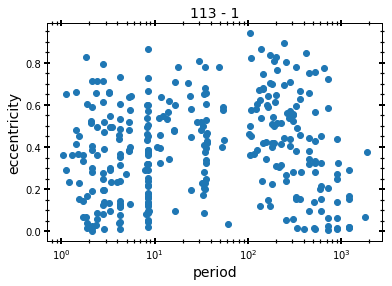

<JokerSamples [P, e, omega, M0, s, K, v0] (9246 samples)>


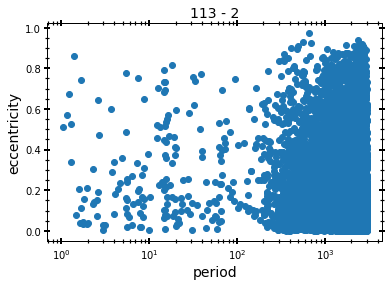

<JokerSamples [P, e, omega, M0, s, K, v0] (10000 samples)>


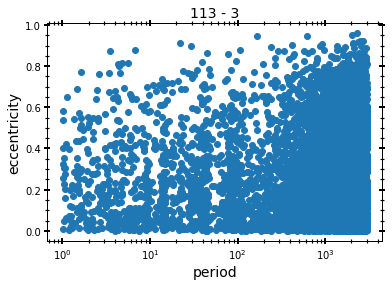

<JokerSamples [P, e, omega, M0, s, K, v0] (3194 samples)>


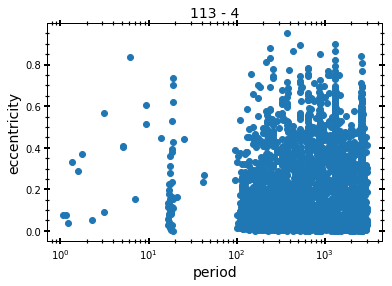

<JokerSamples [P, e, omega, M0, s, K, v0] (30 samples)>


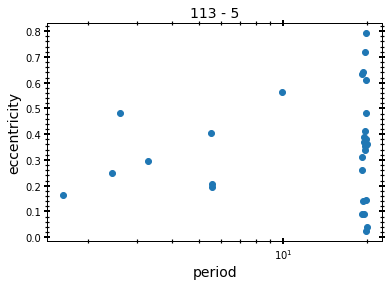

<JokerSamples [P, e, omega, M0, s, K, v0] (3271 samples)>


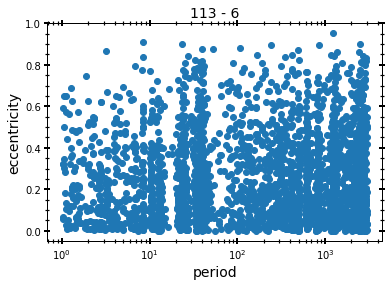

<JokerSamples [P, e, omega, M0, s, K, v0] (41 samples)>


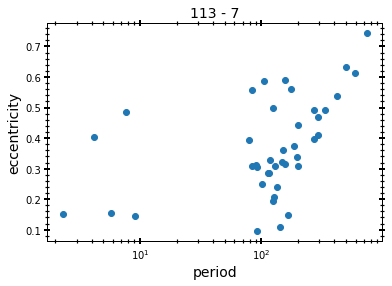

<JokerSamples [P, e, omega, M0, s, K, v0] (1400 samples)>


KeyboardInterrupt: 

In [23]:
def plot_posteriors(obj, program):
    version = 1
    fname = '../joker_samples/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    
    print(joker_samples)


    plt.scatter(joker_samples['P'], joker_samples['e'])
    plt.xscale('log')
    plt.title('%s - %s' % (program,obj))
    plt.xlabel('period')
    plt.ylabel('eccentricity')


    plt.show()

for i in range(1,26,1):
    plot_posteriors(i,113)


In [161]:
def K_amp(obj, program, ax):
    version = 1
    fname  = '../joker_samples/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    dtemp  = rv_df[(rv_df.program==program) & (rv_df.RG_id==obj)]
    
    logg   = dtemp.logg.values[0]
    li_val = dtemp.Li_val.values[0]
    e_li   = dtemp.e_Li_val.values[0]
    
    K      = abs(joker_samples['K'].value)
    perc_5 = np.percentile(K, 5) #km/s
    
    # best-fit line
    threshold = semi_log(2000, 3.5, 10, logg) #m/s
    # 3.5 sigma line
    threshold = semi_log(5000, 4.0, 70, logg)
    threshold/=1000 #km/s
    
    if perc_5 > 0.5: 
        ax.set_title('%s-%s 5th-per: %.2f km/s' % (program, obj, perc_5),fontsize=10)
    if perc_5 > threshold: 
        ax.set_facecolor('lightgreen')
        print(program, obj,'\t','5th-per: %.2f \t threshold: %.2f' % (perc_5, threshold))

    if len(K) != 1:
        K      = np.log10(K)
        ax.hist(K, bins='auto')
        ax.axvline(0, c='green')
        ax.axvline(np.log10(perc_5), c='r')
    
    ax.set_xlabel('log(K)')
    
    if perc_5 > threshold: 
        return True
    else:
        return False
    
plt.figure(figsize=(9,20))
pass_threshold = {113: [], 112: []}
for i in range(1,26,1):
    ax = plt.subplot(9,3,i)
    
    x = K_amp(i,113,ax)
    if x is True: pass_threshold[113].append(i)
        
plt.tight_layout()
plt.close()

plt.figure(figsize=(12,10))
for i,obj in enumerate([1, 2, 4, 5, 6, 7, 14, 23]):
    ax = plt.subplot(4,2,i+1)
    x = K_amp(obj,112,ax)
    if x is True: pass_threshold[112].append(obj)
    
plt.tight_layout()
print(pass_threshold)
plt.close()
# # PROGRAM 112
# for i in :
#     p_val, e_val, li_val, e_li = get_samples(i,112,ax1,ax2)
#     li_vals.append(li_val)
#     p_vals.append(p_val)
#     e_vals.append(e_val)
#     e_li_vals.append(e_li)


113 9 	 5th-per: 0.25 	 threshold: 0.24
113 11 	 5th-per: 0.33 	 threshold: 0.23
113 16 	 5th-per: 15.68 	 threshold: 0.27
113 18 	 5th-per: 24.89 	 threshold: 0.34
113 19 	 5th-per: 1.81 	 threshold: 0.40
113 23 	 5th-per: 8.65 	 threshold: 0.32
112 6 	 5th-per: 1.90 	 threshold: 0.52
112 23 	 5th-per: 7.73 	 threshold: 0.29
{113: [9, 11, 16, 18, 19, 23], 112: [6, 23]}


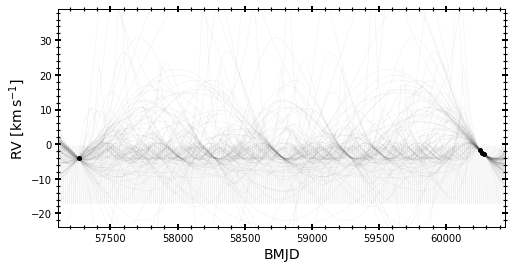

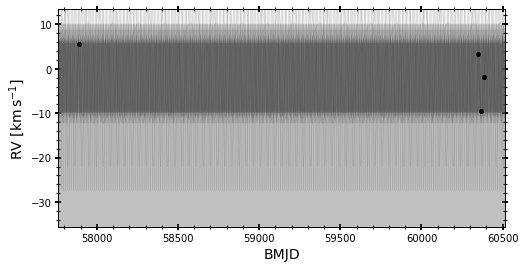

In [159]:
for obj in [6, 23]:
    plot_rvs(obj, 112)


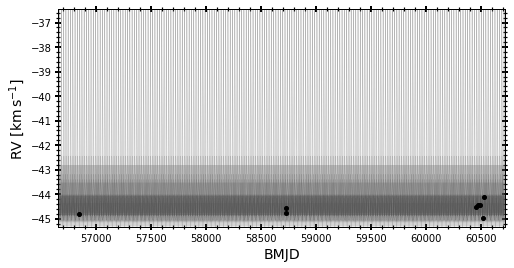

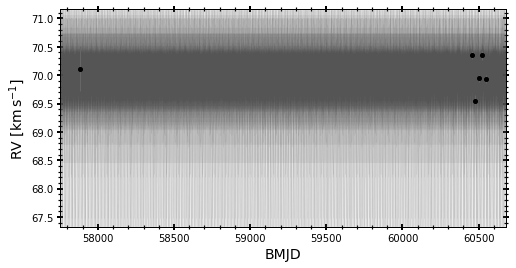

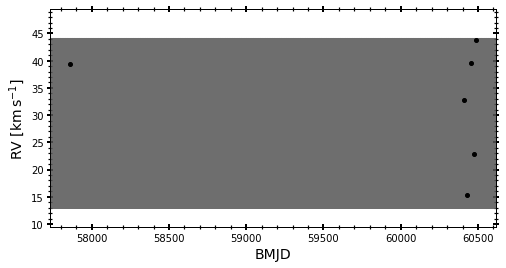

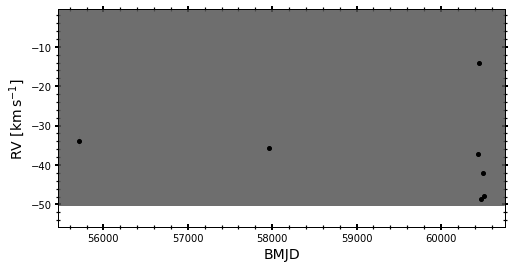

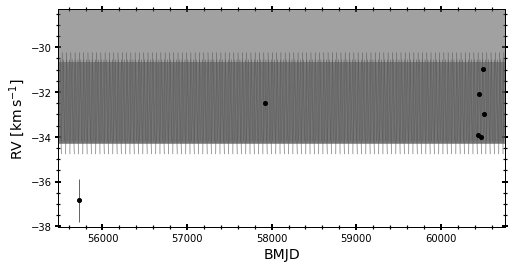

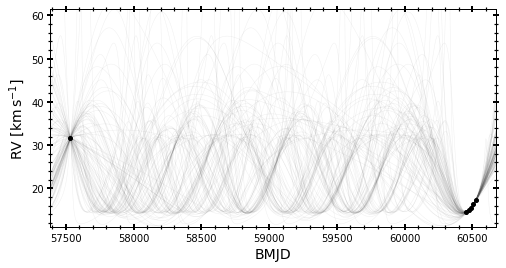

In [160]:

for obj in [9, 11, 16, 18, 19, 23,]:
    plot_rvs(obj, 113)



In [162]:


def plot_rvs(obj, program, N=100):
    version = 1
    fname = '../joker_samples/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    
    galah_id         = rv_df[(rv_df.RG_id==obj) & (rv_df.program==program)].galah_id.values[0]
    dtemp            = comb_df[comb_df.GALAH_ID==galah_id]
    time, rv, err    = dtemp.time.values, dtemp.rv.values, dtemp.rv_err.values
    sources          = np.array(dtemp.source.values)
    time, rv, err    = np.array(time), np.array(rv), np.array(err)

    data             = Table()
    data['bjd']      = time
    data['rv']       = rv
    data['err']      = err
    data["rv"].unit  = u.km / u.s
    data["err"].unit = u.km / u.s
    
    data = tj.RVData(
        t      = Time(data["bjd"], format="jd", scale="tcb"),
        rv     = u.Quantity(data["rv"]),
        rv_err = u.Quantity(data["err"]))
    
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(joker_samples[:N], data=data, ax=ax)
    plt.show()



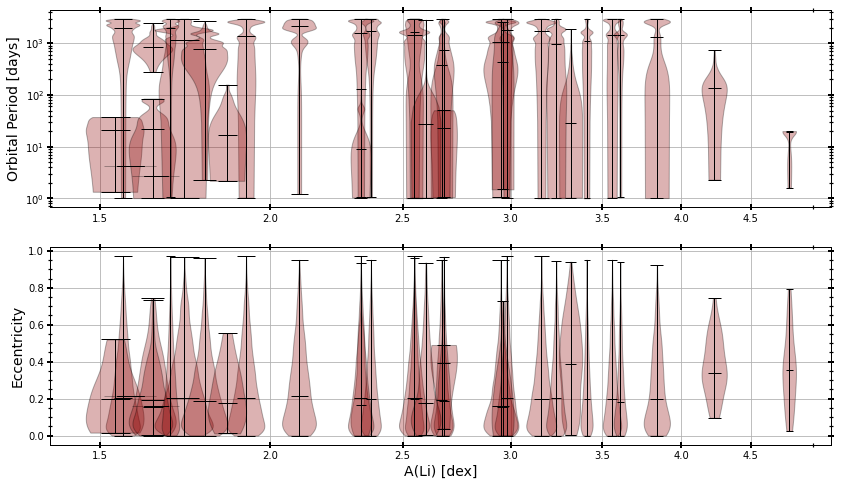

In [175]:
from utils import PLOT_PARAMS
PLOT_PARAMS()
def get_samples(obj, program,ax1,ax2):
    version = 1
    fname  = '../joker_samples/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    dtemp  = rv_df[(rv_df.program==program) & (rv_df.RG_id==obj)]
    li_val = dtemp.Li_val.values[0]
    e_li   = dtemp.e_Li_val.values[0]

    return joker_samples['P'].value, joker_samples['e'].value, li_val, e_li

plt.figure(figsize=(14,8))    
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

e_li_vals = []
li_vals = []
p_vals = []
e_vals = []

# PROGRAM 113
for i in range(1,26,1):
    p_val, e_val, li_val, e_li = get_samples(i,113,ax1,ax2)
    li_vals.append(li_val)
    p_vals.append(p_val)
    e_vals.append(e_val)
    e_li_vals.append(e_li)

# PROGRAM 112
for i in [1, 2, 4, 5, 6, 7, 14, 23]:
    p_val, e_val, li_val, e_li = get_samples(i,112,ax1,ax2)
    li_vals.append(li_val)
    p_vals.append(p_val)
    e_vals.append(e_val)
    e_li_vals.append(e_li)


# PLOTTING
vp1 = ax1.violinplot(p_vals,showmeans=False,showmedians=True,positions=li_vals,widths=e_li_vals)
vp2 = ax2.violinplot(e_vals,showmeans=False,showmedians=True,positions=li_vals,widths=e_li_vals)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_ylabel('Orbital Period [days]')
ax2.set_ylabel('Eccentricity')
ax2.set_xlabel('A(Li) [dex]')


for pc in vp1['bodies']:
    pc.set_facecolor('darkred')
    pc.set_edgecolor('k')
    
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = vp1[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(1)

for pc in vp2['bodies']:
    pc.set_facecolor('darkred')
    pc.set_edgecolor('k')
    
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = vp2[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(1)

pos     = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]
labels  = ['%.1f' % i for i in pos]
_      = ax1.set_xticks(pos)
_      = ax2.set_xticks(pos)
_ = ax1.set_xticklabels(labels)
_ = ax2.set_xticklabels(labels)

ax1.grid()
ax2.grid()

# plt.savefig('../plots/violin_plot_%s.png'%DATE,bbox_inches='tight',dpi=150)

-0.6574371416182804 3.3010299956639813
-0.4634679910804405 3.6989700043360187


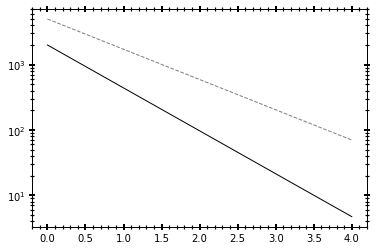

In [179]:

def semi_log(y1, x2, y2, x, x1=0):
    b = np.log10(y1)
    m = (1./x2)*np.log10(y2/y1)
    y = 10**(m*x+b)
    print(m, b)
    return y
x = np.linspace(0,4,100)    

y1=semi_log(2000, 3.5, 10, x)
# y2=semi_log(1000, 2.4, 10, x)
y3=semi_log(5000, 4.0, 70, x)

plt.plot(x,y1, c='k',ls='solid',lw=1)
# plt.plot(x,y2, c='grey',ls='dashed',label=r'$3.5\sigma$',lw=1)
plt.plot(x,y3, c='grey',ls='dashed',lw=1)
# plt.scatter(2,semi_log(2000, 3.5, 10, 2),c='r')
plt.yscale('log')